# Plot the Results 

First load moduls and implement basic functions:

In [1]:
from statistics import mean
import json
import re
from typing import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import pandas as pd
plt.style.use('seaborn-v0_8')  # seaborn-v0_8-paper    seaborn-v0_8-whitegrid
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [2]:
colors =  plt.cm.tab20c( (4./3*np.arange(20*3/4)).astype(int) )
# set color for each setting
color_dict = {
    'M': colors[6],
    'X': colors[7],
    'X + DEN': colors[0],
    'X + FEN': colors[1],
    'X + KEN': colors[2],
    'M + NLI': colors[3],
    'M + NLI (strategies)': colors[3],
    'X + NLI': colors[4],
    'X + NLI (strategies)': colors[4],
    'X + XNLI': colors[5],
    'X + XNLI (strategies)': colors[5],
    'X + XNLI + DEN': colors[9],
    'X + XNLI + DEN (strategies)': colors[9],
    'X + XNLI + FEN': colors[10],
    'X + XNLI + FEN (strategies)': colors[10],
    'X + XNLI + KEN': colors[11],
    'X + XNLI + KEN (strategies)': colors[11]
}

# define sorting for settings 
# custom_sort_dict = {
#     ('M', None): 1,
#     ('X', None): 2,
#     ('X + DEN', None): 3,
#     ('X + FEN', None): 4,
#     ('X + KEN', None): 5,
#     ('M + NLI', 'baseline'): 6,
#     ('M + NLI', 'strategy'): 7,
#     ('X + NLI', 'baseline'): 8,
#     ('X + NLI', 'strategy'): 9,
#     ('X + XNLI', 'baseline'): 10,
#     ('X + XNLI', 'strategy'): 11,
#     ('X + XNLI + DEN', 'baseline'): 12,
#     ('X + XNLI + DEN', 'strategy'): 13,
#     ('X + XNLI + FEN', 'baseline'): 14,
#     ('X + XNLI + FEN', 'strategy'): 15,
#     ('X + XNLI + KEN', 'baseline'): 16,
#     ('X + XNLI + KEN', 'strategy'): 17
# }

custom_sort_dict = {
    'M': 1,
    'X': 2,
    'X + DEN': 3,
    'X + FEN': 4,
    'X + KEN': 5,
    'M + NLI': 6,
    'M + NLI (strategies)': 7,
    'X + NLI': 8,
    'X + NLI (strategies)': 9,
    'X + XNLI': 10,
    'X + XNLI (strategies)': 11,
    'X + XNLI + DEN': 12,
    'X + XNLI + DEN (strategies)': 13,
    'X + XNLI + FEN': 14,
    'X + XNLI + FEN (strategies)': 15,
    'X + XNLI + KEN': 16,
    'X + XNLI + KEN (strategies)': 17,
    'strategy': 18
}

# deprecated color mapping
# color_dict = {
#     'M': 'seagreen',
#     'X': 'xkcd:gray blue',
#     'X + DEN': 'cornflowerblue',
#     'X + FEN': 'royalblue',
#     'X + KEN': 'darkblue',
#     'M + NLI': 'tomato',
#     'X + NLI': 'crimson',
#     'X + XNLI': 'darkred',
#     'X + XNLI + DEN': 'violet',
#     'X + XNLI + FEN': 'darkviolet',
#     # 'X + XNLI + KEN': ?,
# }



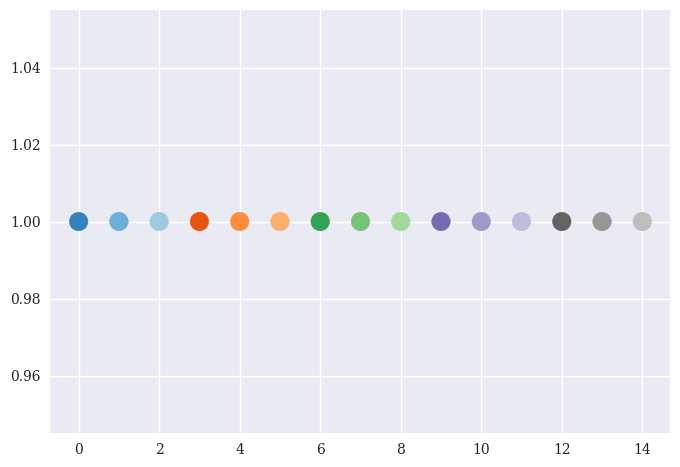

In [3]:
plt.scatter(np.arange(15),np.ones(15), c=colors, s=180)
plt.show()

## Load Results and Parse into Format

In [4]:
df1 = pd.read_csv('/srv/scratch1/jgoldz/xnli-for-multilingual-hate-speech-detection/results/nli_agg_results/raw_results.csv')
df2 = pd.read_csv('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/results/no_nli_agg_results/raw_results.csv')
df_results = pd.concat([df1, df2], ignore_index=True)
df_results = df_results[~df_results['test_set'].isin(['MHC_FR', 'OUS19_FR'])]
df_results['nli'] = df_results['english_corpus'].str.contains('NLI')

def map_setting(value):
    if value == 'monoling_target_lang':
        return 'M'
    elif value == 'X':
        return 'X'
    elif value in ['X_DEN', 'X_FEN', 'X_KEN']:
        return value.replace('_', ' + ')
    elif value == 'M_mNLI':
        return 'M + NLI'
    elif value == 'X_mNLI':
        return 'X + NLI'
    elif value == 'X_NLI':
        return 'X + XNLI'
    elif value in ['X_NLI_DEN', 'X_NLI_FEN', 'X_NLI_KEN']:
        return value.replace('_', ' + ').replace('NLI', 'XNLI')
    else:
        raise Exception(f'Unexpected value: {value}')
    
def map_strategy(value):
    if value == 'FBT_tc_FC_FRS':
        return True
    return False

def add_setting_strat_column(df):
    df['setting_strat'] = df.apply(lambda row: row['setting'] + ' (strategies)' if row['strategy'] == True else row['setting'], axis=1)
    return df


# Map setting and strategy names
df_results['setting'] = df_results['english_corpus'].apply(map_setting)
df_results['strategy'] = df_results['strategy'].apply(map_strategy)
df_results['run'] = df_results['run'].replace(r'^RUN', '', regex=True).astype(int)
# Create new combined column
# df_results['setting_strat'] = df_results['setting'] + ' (' + df_results['strategy'] + ')'
# df_results['setting_strat'] = df_results['setting'] + ' (' + df_results['strategy'].where(df_results['strategy'] == 'strategy', '') + ')'
df_results = add_setting_strat_column(df_results)
# Drop unnecessary columns
df_results = df_results.drop(['model', 'english_corpus', 'nli', 'accuracy'], axis=1)  # setting

# reindexing and naming
df_results = df_results.reindex(columns=['test_set', 'target_lang_examples', 'setting_strat', 'strategy', 'run', 'macro-f1'])
df_results = df_results.rename(columns={'target_lang_examples': 'trainsize'})
trainsize_mapping = {0: 0, 20: 1, 200: 2, 2000: 3}
df_results['trainsize'] = df_results['trainsize'].map(trainsize_mapping)

# Create one dataframe per test set
result_dict = {}
for key in df_results['test_set'].unique():
    filtered_df = df_results[df_results['test_set'] == key]
    filtered_df = filtered_df.drop(['test_set'], axis=1)
    df_pivot = filtered_df.pivot_table(
        index=['trainsize'],
        values='macro-f1',
        columns=['setting_strat', 'strategy', 'run'],
        # aggfunc=list
    )
    result_dict[key] = df_pivot

results_dict_held_out = {k: result_dict[k] for k in result_dict if 'MHC' not in k}
results_dict_mhc = {k: result_dict[k] for k in result_dict if 'MHC' in k}

In [5]:
def custom_legend(legend_elements, ncol, nrows):
    # Create a new list of elements for the legend
    new_elements = [None]*ncol*nrows
    
    # Loop over the original legend elements and distribute them over the new list
    for i, element in enumerate(legend_elements):
        new_elements[i%nrows + (i//nrows)*nrows] = element
    return new_elements


def copy_lines_and_update(lines):
    updated_lines = []
    for line in lines:
        updated_lines.append(line)
        if 'strategy' in line.get_label():
            # Create a new Line2D object which is a copy of the original, but with a dashed linestyle and an updated label
            new_line = Line2D(line.get_xdata(), line.get_ydata(), lw=line.get_linewidth(),
                              label=line.get_label(), color=line.get_color(), linestyle='--')
            updated_lines.append(new_line)
    return updated_lines

def custom_sort(label):
    try:
        return custom_sort_dict[label]
    except KeyError:
        raise Exception(f'Unexpected setting: {label}')

def exclude_settings(df, settings):
    cols = []
    # setting_tuples = [(setting.rstrip(' (strategies)', 'strategies')]
    # for col in df.columns:
    #     if col[0] in settings:
    #         cols.append(col)
    #     elif col[0] + ' (strategy)' in settings and 'strategy' in settings:
    #         cols.append(col)
    for setting in settings:
        for col in df.columns:
            if col[0] == setting:
                cols.append(col)
            # elif 'strategy' in setting and col[0] == setting.rstrip(' (strategy)') and col[2] == True:
            #     cols.append(col)
        # cols.extend([col for col in df.columns if col[0] == setting])
    df = df.drop(columns=cols, axis=1)
    return df

def include_settings(df, settings):
    settings_to_exclude = set(color_dict.keys()) - set(settings)
    return exclude_settings(df, settings_to_exclude)

def exclude_settings_dict(d, settings):
    return {k: exclude_settings(df, settings) for k, df in d.items()}

def include_settings_dict(d, settings):
    return {k: include_settings(df, settings) for k, df in d.items()}

def calculate_pointwise_average(*dataframes):
    if len(dataframes) < 1:
        raise ValueError("At least one dataframe must be provided.")

    summed_df = dataframes[0]
    for df in dataframes[1:]:
        summed_df = summed_df.add(df)

    average_df = summed_df.div(len(dataframes))
    return average_df

In [6]:
settings_to_include = ['X', 'X + DEN', 'X + FEN', 'X + XNLI', 'X + XNLI + DEN', 'X + XNLI + FEN']
filtered_df = include_settings_dict(result_dict, settings_to_include)
print(set([(col[0], col[1]) for col in filtered_df['BAS19_ES'].columns]))

{('X + FEN', False), ('X + DEN', False), ('X', False), ('X + XNLI + DEN', False), ('X + XNLI', False), ('X + XNLI + FEN', False)}


## Load baselines

In [7]:
def get_macro_f1_random_prediction(fpath: str) -> float:
    with open(fpath) as fin:
        return json.load(fin)['macro_f1_random_prediction']

def get_macro_f1_never_hate(fpath: str) -> float:
    with open(fpath) as fin:
        return json.load(fin)['macro_f1_never_hate']

def get_macro_f1_always_hate(fpath: str) -> float:
    with open(fpath) as fin:
        return json.load(fin)['macro_f1_always_hate']

baselines_random_pred = {
    'MHC_ES': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_ES_test_3745_stats.json'),
    'MHC_PT': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_PT_test_3691_stats.json'),
    'MHC_HI': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_HI_test_3565_stats.json'),
    'MHC_AR': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_AR_test_3570_stats.json'),
    'MHC_IT': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_IT_test_3690_stats.json'),
    'BAS19_ES': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/BAS19_ES/BAS19_ES_test_2000_stats.json'),
    'FOR19_PT': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/FOR19_PT/FOR19_PT_test_2000_stats.json'),
    'HAS21_HI': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/HAS21_HI/HAS21_HI_test_500_stats.json'),
    'OUS19_AR': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/OUS19_AR/OUS19_AR_test_1000_stats.json'),
    'SAN20_IT': get_macro_f1_random_prediction('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/SAN20_IT/SAN20_IT_test_2000_stats.json')
}
baselines_never_hate = {
    'MHC_ES': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_ES_test_3745_stats.json'),
    'MHC_PT': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_PT_test_3691_stats.json'),
    'MHC_HI': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_HI_test_3565_stats.json'),
    'MHC_AR': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_AR_test_3570_stats.json'),
    'MHC_IT': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_IT_test_3690_stats.json'),
    'BAS19_ES': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/BAS19_ES/BAS19_ES_test_2000_stats.json'),
    'FOR19_PT': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/FOR19_PT/FOR19_PT_test_2000_stats.json'),
    'HAS21_HI': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/HAS21_HI/HAS21_HI_test_500_stats.json'),
    'OUS19_AR': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/OUS19_AR/OUS19_AR_test_1000_stats.json'),
    'SAN20_IT': get_macro_f1_never_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/SAN20_IT/SAN20_IT_test_2000_stats.json')
}

baselines_always_hate = {
    'MHC_ES': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_ES_test_3745_stats.json'),
    'MHC_PT': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_PT_test_3691_stats.json'),
    'MHC_HI': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_HI_test_3565_stats.json'),
    'MHC_AR': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_AR_test_3570_stats.json'),
    'MHC_IT': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/MHC/MHC_IT_test_3690_stats.json'),
    'BAS19_ES': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/BAS19_ES/BAS19_ES_test_2000_stats.json'),
    'FOR19_PT': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/FOR19_PT/FOR19_PT_test_2000_stats.json'),
    'HAS21_HI': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/HAS21_HI/HAS21_HI_test_500_stats.json'),
    'OUS19_AR': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/OUS19_AR/OUS19_AR_test_1000_stats.json'),
    'SAN20_IT': get_macro_f1_always_hate('/srv/scratch0/jgoldz/xnli-for-multilingual-hate-speech-detection/data/processed/SAN20_IT/SAN20_IT_test_2000_stats.json')
}

## All Results per Language

In [8]:
def add_plot_to_fig(df, title: str, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    ax.set_title(title, fontsize=17)
    df_reset = df.reset_index()
    # convert the DataFrame from wide to long format
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    # now 'setting_strat' is a regular column and can be used in seaborn
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator="mean", marker="o", dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, markeredgecolor='none', palette=color_dict)  # err_kws={'alpha': 0.12}
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-40, 3), fontsize=12, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-70, 3), fontsize=12, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-78, 3), fontsize=12, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    x_points = [0, 1, 2, 3]
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=13)
        ax.set_xlabel('N', fontsize=15)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
        ax.set_xlabel('', fontsize=15)
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=13)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
    
    # Add a custom legend entry for the dashed line
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(result_dict, test_set_to_ax, fpath):
    # Create a figure with a 2x4 grid
    fig = plt.figure(figsize=(16, 9), layout='constrained')
    grid = plt.GridSpec(2, 4, fig)

    # Merge the first two columns and rows
    ax0 = fig.add_subplot(grid[0:2, 0:2])

    # Create the other subplots
    ax1 = fig.add_subplot(grid[0, 2])
    ax2 = fig.add_subplot(grid[0, 3])
    ax3 = fig.add_subplot(grid[1, 2])
    ax4 = fig.add_subplot(grid[1, 3])
    
    flat_axes = [ax0, ax1, ax2, ax3, ax4]

    for test_set, test_set_df in result_dict.items():
        print(test_set, end='\r')
        ax = flat_axes[test_set_to_ax[test_set]]
        annotate_x_axis = True if test_set_to_ax[test_set] in [0, 3, 4] else False
        annotate_y_axis = True if test_set_to_ax[test_set] in [0, 1, 3] else False
        if test_set == 'BAS19_ES' or test_set == 'MHC_ES':
            legend_elements = add_plot_to_fig(test_set_df, title=test_set, f1_rand_pred=baselines_random_pred[test_set], f1_never_hate=baselines_never_hate[test_set], f1_always_hate=baselines_always_hate[test_set], ax=ax, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(test_set_df, title=test_set, f1_rand_pred=baselines_random_pred[test_set], f1_never_hate=baselines_never_hate[test_set], f1_always_hate=baselines_always_hate[test_set], ax=ax, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)

    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')] 
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', prop={'size': 14}, ncol=4,  fancybox=False, shadow=False, frameon=True, handlelength=2.2, handleheight=0.8)  # fontsize=12,
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('white')

    plt.savefig(fpath, format='pdf')
    plt.show()

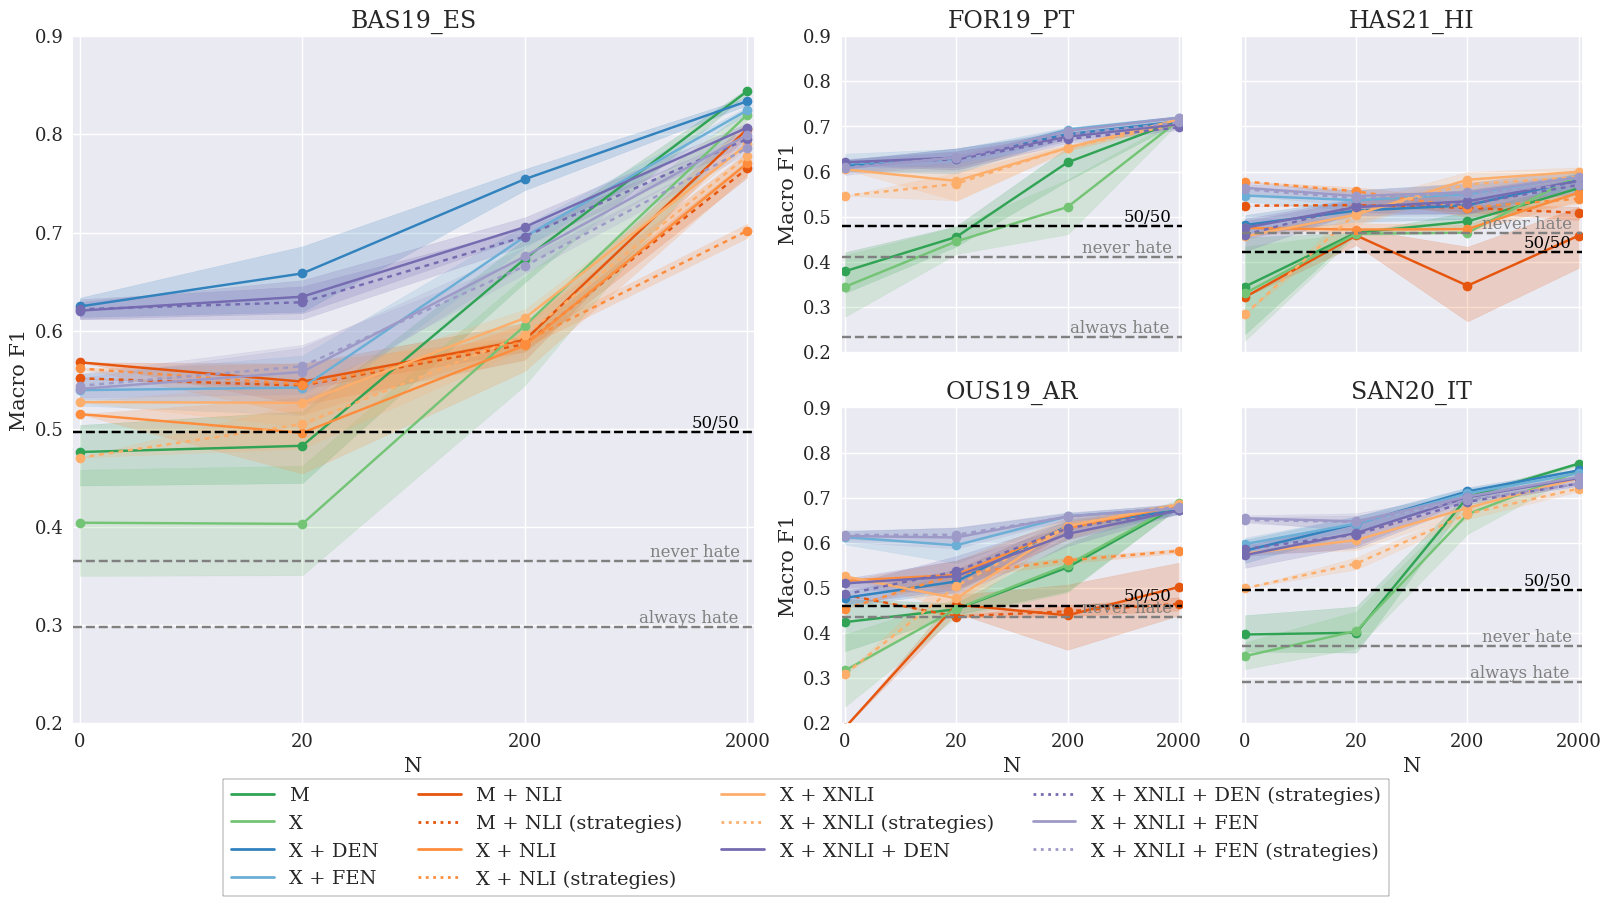

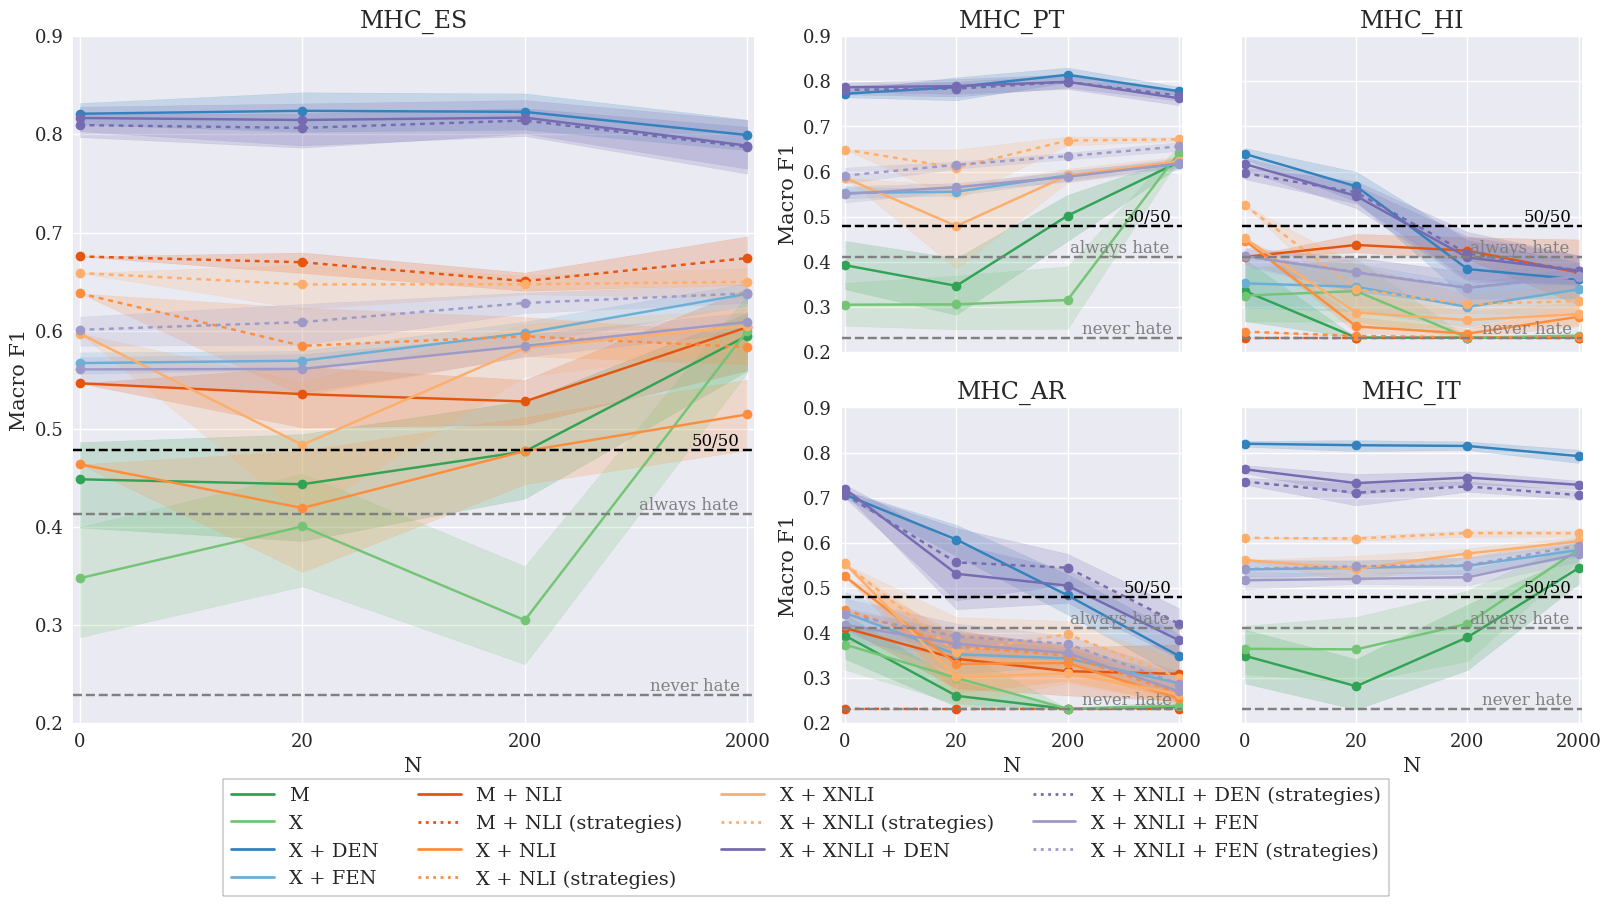

In [9]:
test_set_to_ax_natural = {'BAS19_ES': 0, 'FOR19_PT': 1, 'HAS21_HI': 2, 'OUS19_AR': 3, 'SAN20_IT': 4}
test_set_to_ax_MHC = {'MHC_ES': 0, 'MHC_PT': 1, 'MHC_HI': 2, 'MHC_AR': 3, 'MHC_IT': 4}

settings_to_include = [setting for setting in color_dict.keys() if 'KEN' not in setting]
create_multi_plot_figure(include_settings_dict(results_dict_held_out, settings_to_include), test_set_to_ax_natural, f'plots/natural_datasets_ci.pdf')
create_multi_plot_figure(include_settings_dict(results_dict_mhc, settings_to_include), test_set_to_ax_MHC, f'plots/mhc_datasets_ci.pdf')


## How Does an NLI-Formulation Compare to Röttger et al. (2022a)? 

## Barplot version

In [10]:
def compute_diff(testset, setting1, setting2):
    """Compute the difference between two settings. 
    
    The first setting (baseline) is subtracted from the second setting (method of interest).
    """
    df_1 = result_dict[testset].loc[:, (setting1, slice(None), slice(None))].copy()
    df_2 = result_dict[testset].loc[:, (setting2, slice(None), slice(None))].copy()

    df_1.columns = df_1.columns.droplevel()
    df_2.columns = df_2.columns.droplevel()
    diff_df = df_2 - df_1
    
    new_name = f'diff_{setting1}_{setting2}'
    new_index_values = [new_name] * len(df_1.columns)

    strategies, runs = zip(*df_1.columns)
    
    new_columns = pd.MultiIndex.from_arrays([new_index_values, strategies, runs], names=['setting_strat', 'strategy', 'run'])

    diff_df.columns = new_columns
    return diff_df


result_dict_filtered = {k: v for k, v in result_dict.items() if 'PT' not in k and 'IT' not in k}

diff_settings = [('M', 'M + NLI'), ('X', 'X + NLI'), ('X', 'X + XNLI'), ('X', 'X + DEN'), ('X', 'X + FEN')]
for testset in result_dict_filtered:
    for s1, s2 in diff_settings:
        result_dict_filtered[testset] = pd.concat([result_dict_filtered[testset], compute_diff(testset, s1, s2)], axis=1)


settings_to_include = ['M_M + NLI', 'X_X + NLI', 'X_X + XNLI', 'X_X + DEN', 'X_X + FEN']
filtered_dfs = include_settings_dict(result_dict_filtered, settings_to_include)


result_dict_filtered['held_out_AR_ES_HI'] = calculate_pointwise_average(filtered_dfs['OUS19_AR'], filtered_dfs['BAS19_ES'], filtered_dfs['HAS21_HI'])
result_dict_filtered['MHC_AR_ES_HI'] = calculate_pointwise_average(filtered_dfs['MHC_AR'], filtered_dfs['MHC_ES'], filtered_dfs['MHC_HI'])


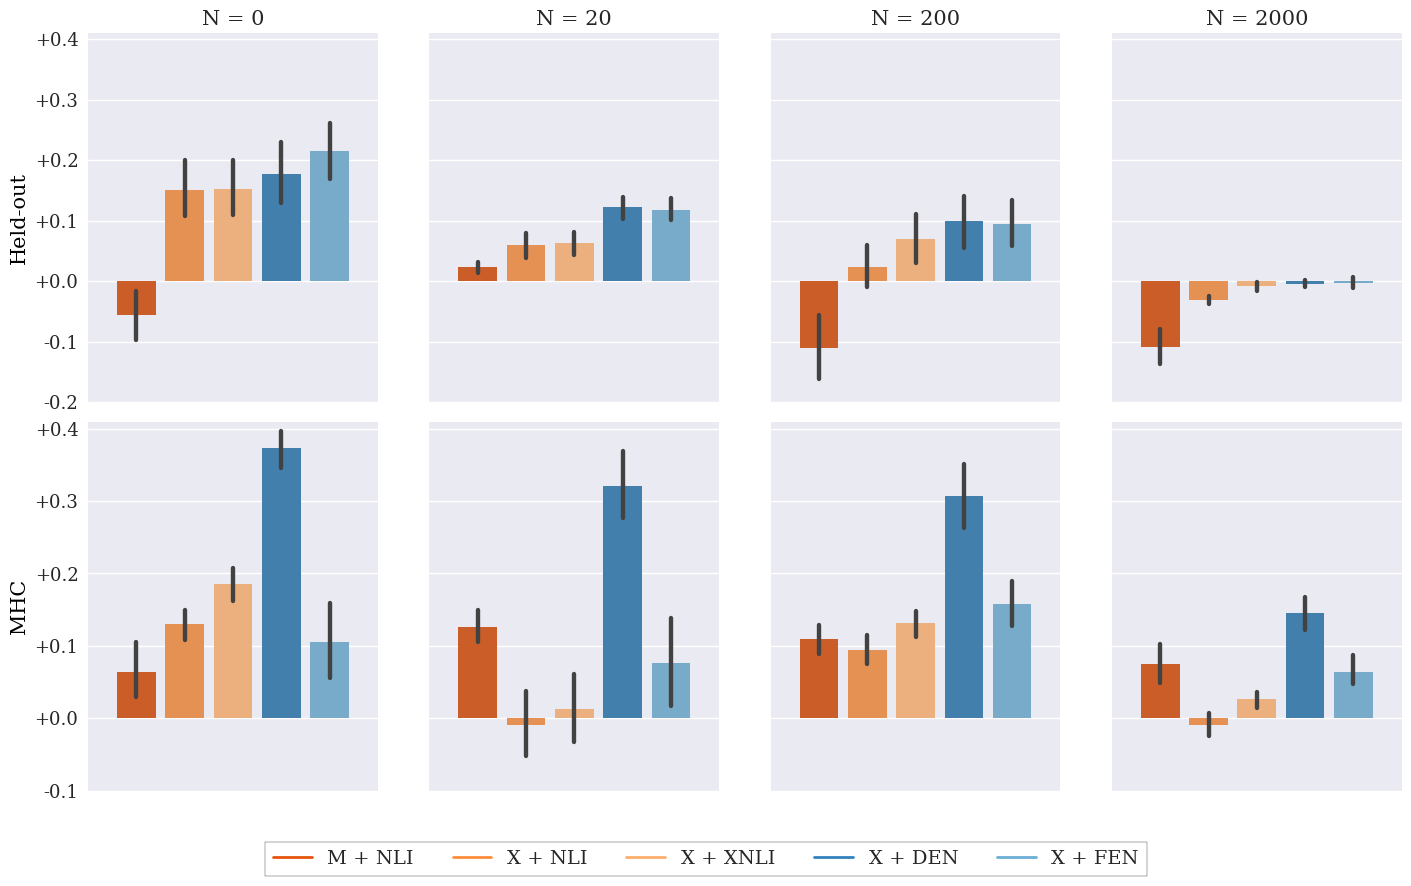

In [11]:
import scipy.stats as stats

setting_to_ax = {
    'Held-out_diff_f1_scores_0': 0,
    'Held-out_diff_f1_scores_20': 1, 
    'Held-out_diff_f1_scores_200': 2, 
    'Held-out_diff_f1_scores_2000': 3, 
    'MHC_diff_f1_scores_0': 4, 
    'MHC_diff_f1_scores_20': 5,
    'MHC_diff_f1_scores_200': 6,
    'MHC_diff_f1_scores_2000': 7
}
y_lims = {
    'Held-out': (-0.2, 0.41),
    'MHC': (-0.1, 0.41)
}


def sign_formatter(x, pos):
    if x >= 0:
        return '+{}'.format(x)
    else:
        return '{}'.format(x)

def add_plot_to_fig(title: str, df, num_shots: int, ax, fig, annotate_x_axis: bool = True, annotate_y_axis: bool = True, y_lim=(-0.2, 0.4)) -> None:  # list_of_colors: List[str], f1_rand_pred: float, f1_never_hate: float, f1_always_hate, 
    x_points = [0.5, 1.5, 2.5, 3.5, 4.5]
    df_new = df.rename(columns={'diff_M_M + NLI': 'M + NLI', 'diff_X_X + NLI': 'X + NLI', 'diff_X_X + XNLI': 'X + XNLI', 'diff_X_X + DEN': 'X + DEN', 'diff_X_X + FEN': 'X + FEN'}, level='setting_strat')
    colors = [color_dict[setting] for setting in ['M + NLI', 'X + NLI', 'X + XNLI', 'X + DEN', 'X + FEN']]
    df_reset = df_new.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='f1')
    df_long = df_long.loc[df_long['trainsize'] == num_shots]
    df_long = df_long.drop(['trainsize', 'strategy'], axis=1)
    
    p_ax = sns.barplot(x='setting_strat', y='f1', data=df_long, estimator=np.mean, errorbar=('ci', 95), ax=ax, palette=color_dict)
    p_ax.figure.canvas.draw()

    labels = [item.get_text() for item in ax.get_xticklabels()]
    fig = plt.gcf()

    fig.canvas.draw()
    
    ax.set_xlim(-1, len(df_long['setting_strat'].unique()))
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xlabel('N', fontsize=15)
        ax.set_xticklabels(['', '', '', '', ''])
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', '', ''])
        ax.set_xlabel('', fontsize=15)
    
    
    ytick_values = [y/100 for y in range(-30, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=13)
        ax.set_ylim(y_lim)
        ax.set_ylabel('Diff. Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(y_lim)
        ax.set_ylabel('', fontsize=15)
        
    legend_elements = []
    for label, color in zip(labels, colors):
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=color, linestyle='-'))
        
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(sign_formatter))
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, fpath, title):
    fig, axs = plt.subplots(2, 4, figsize=(14, 8), layout='constrained')    
    axs_list = axs.flatten()

    df_held_out, df_mhc = result_dict_filtered['held_out_AR_ES_HI'], result_dict_filtered['MHC_AR_ES_HI']
    for testset_type, test_df in zip(['Held-out', 'MHC'], [df_held_out, df_mhc]):
        for num_shots in ['diff_f1_scores_0', 'diff_f1_scores_20', 'diff_f1_scores_200', 'diff_f1_scores_2000']:
            setting = f'{testset_type}_{num_shots}'
            ax = axs_list[setting_to_ax[setting]]
            num_shots_int = {0: 0, 20: 1, 200: 2, 2000: 3}[int(re.search(r'\d+$', num_shots).group())]
            annotate_x_axis = True if setting_to_ax[setting] in [] else False
            annotate_y_axis = True if setting_to_ax[setting] in [0, 4] else False
            legend_elements = add_plot_to_fig(
                title='NLI fine-tuning Evaluated on Languages in XNLI', 
                df=test_df,
                num_shots=num_shots_int,
                ax=ax, fig=fig, 
                annotate_x_axis=annotate_x_axis, 
                annotate_y_axis=annotate_y_axis,
                y_lim=y_lims['MHC'] if 'MHC' in testset_type else y_lims['Held-out']
            )

    for ax, col in zip(axs[0], ['N = 0', 'N = 20', 'N = 200', 'N = 2000']):
        ax.set_title(col, fontsize=15)
    for ax, row in zip(axs[:,0], ['Held-out', 'MHC']):
        ax.set_ylabel(row, rotation=90, fontsize=15, color='black')

    legend1 = fig.legend(handles=legend_elements, loc='outside lower center', bbox_to_anchor=(0.5, -0.1), fontsize=14, fancybox=False, shadow=False, ncol=7, frameon=True) # , f
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')

    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, format='pdf', bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()

create_multi_plot_figure(result_dict_filtered, f'plots/compare_to_rottger_seen_languages_bar_diff_plots_ci.pdf', title=None)

## Are there Benefits to NLI-Finetuning when given English Hate Speech Data?

In [12]:
def add_plot_to_fig(title: str, df, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    x_points = [0, 1, 2, 3]
    df_reset = df.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator='mean', marker='o', dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, palette=color_dict, markeredgecolor='none')  # err_kws={'alpha': 0.12},  edgecolor='none' 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
        ax.set_xlabel('', fontsize=15)
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
        
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(2, 5, figsize=(16, 9), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        print(testset, end='\r')
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [5, 6, 7, 8, 9] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0, 5] else False
        f1_rand_pred = baselines_random_pred[testset]
        f1_never_hate = baselines_never_hate[testset]
        f1_always_hate = baselines_always_hate[testset]
        
        if testset == 'BAS19_ES':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset,  df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)


    for ax, col in zip(axs[0], ['Spanish', 'Portuguese', 'Hindi', 'Arabic', 'Italian']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs[:,0], ['Held-out', 'MHC']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black')
    
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.08), fontsize=16, fancybox=False, shadow=False, ncol=6, frameon=True) # , f handlelength=1.2
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()

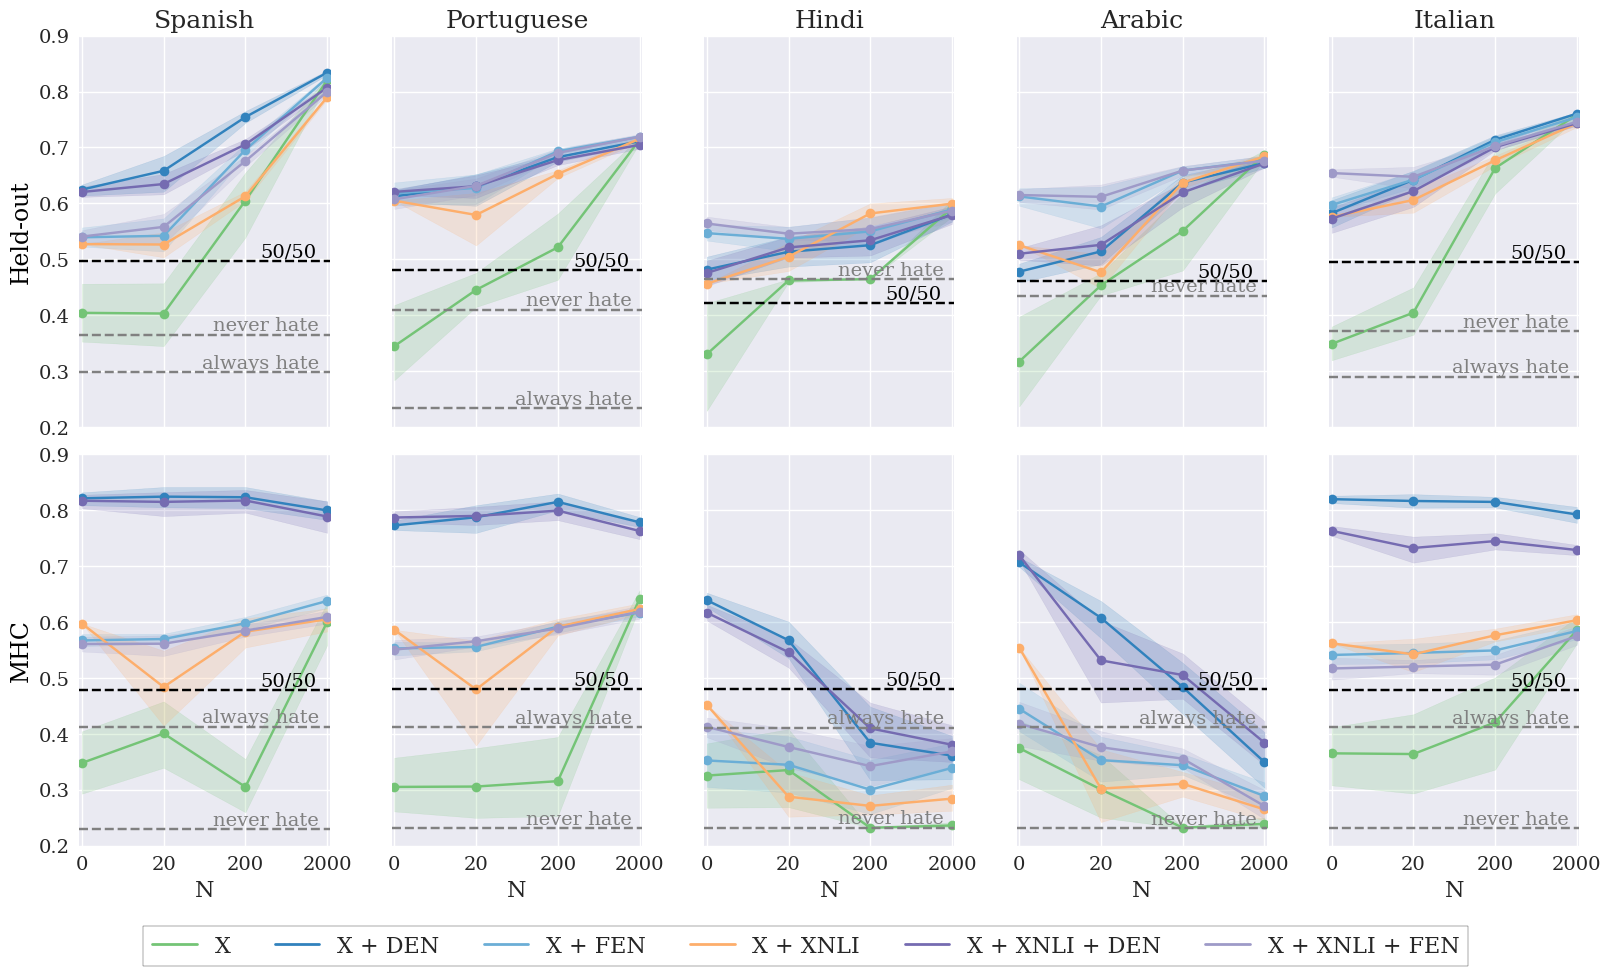

In [13]:
settings_to_include = ['X', 'X + DEN', 'X + FEN', 'X + XNLI', 'X + XNLI + DEN', 'X + XNLI + FEN']
test_set_to_ax = {'BAS19_ES': 0, 'FOR19_PT': 1, 'HAS21_HI': 2, 'OUS19_AR': 3, 'SAN20_IT': 4, 'MHC_ES': 5, 'MHC_PT': 6, 'MHC_HI': 7, 'MHC_AR': 8, 'MHC_IT': 9}

create_multi_plot_figure(include_settings_dict(result_dict, settings_to_include), test_set_to_ax, f'plots/compare_to_rottger_nli_with_en_HS_ci.pdf', title=None)

## Does Hypothesis Engineering Help?

In [14]:
def add_plot_to_fig(title: str, df, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    
    x_points = [0, 1, 2, 3]
    df_reset = df.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator="mean", marker="o", dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), markeredgecolor='none', err_style='band', ax=ax, palette=color_dict)  # err_kws={'alpha': 0.1}, markeredgecolor='none', 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]

    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
        ax.set_xlabel('', fontsize=15)
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
        
    
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(2, 5, figsize=(16, 9), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        print(testset, end='\r')
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [5, 6, 7, 8, 9] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0, 5] else False
        f1_rand_pred = baselines_random_pred[testset]
        f1_never_hate = baselines_never_hate[testset]
        f1_always_hate = baselines_always_hate[testset]
        
        if testset == 'BAS19_ES':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)

    for ax, col in zip(axs[0], ['Spanish', 'Portuguese', 'Hindi', 'Arabic', 'Italian']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs[:,0], ['Held-out', 'MHC']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black')
    
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.11), fontsize=16, fancybox=False, shadow=False, ncol=4, frameon=True) # , f handlelength=1.2
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()

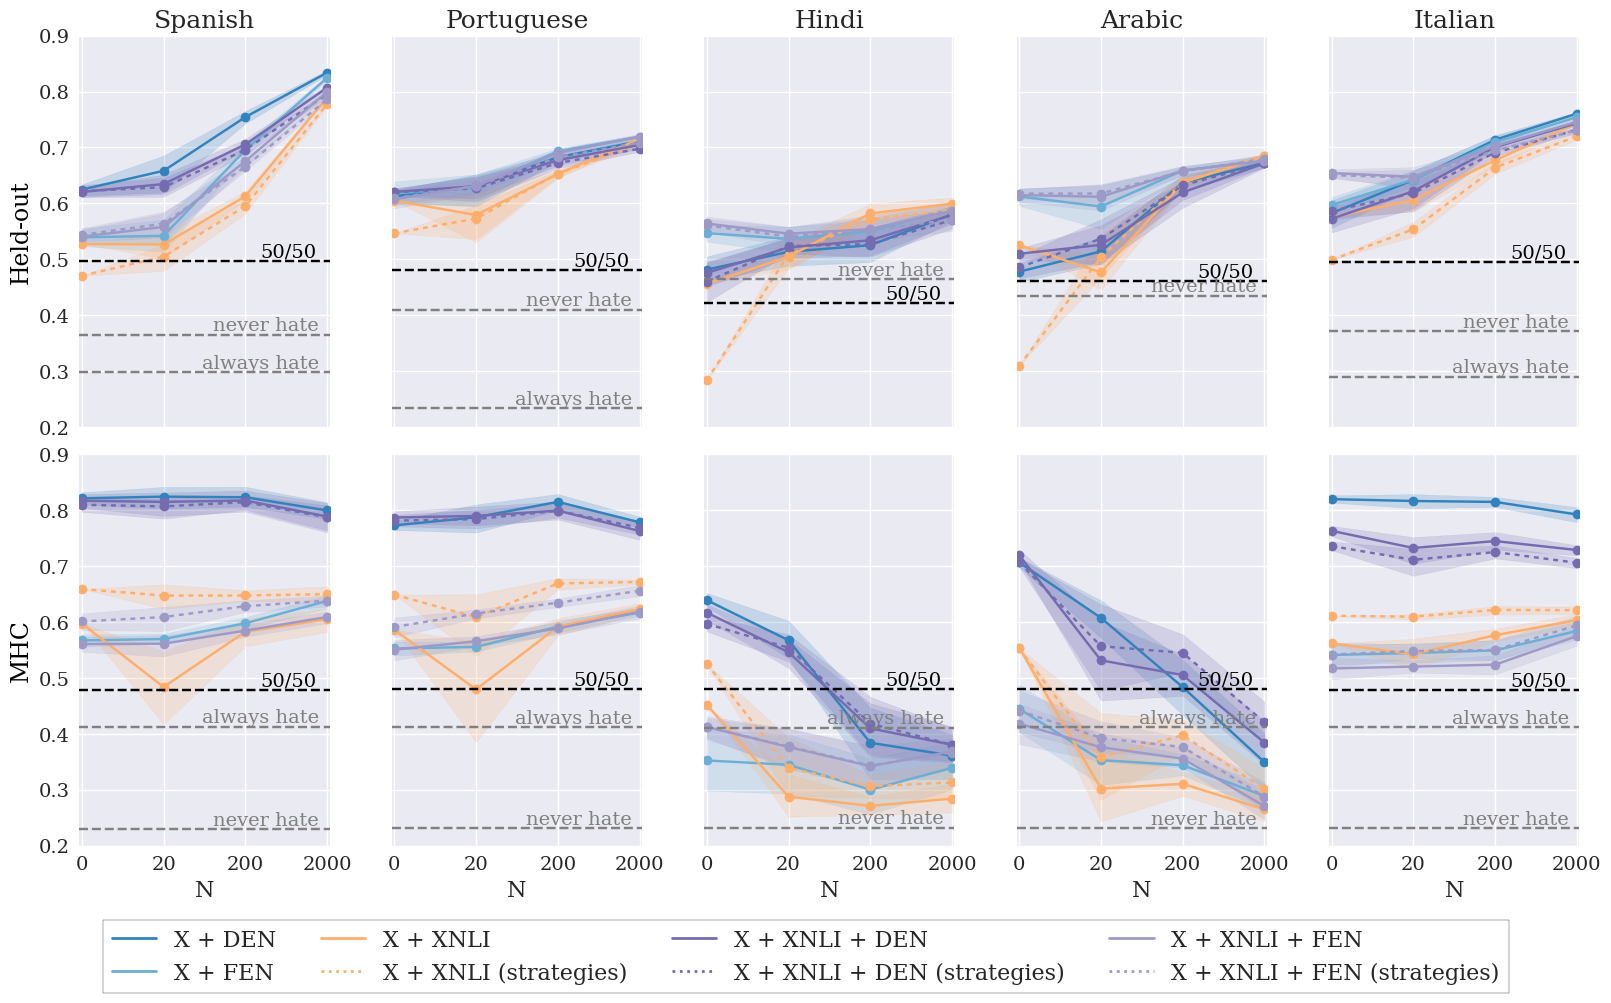

In [15]:
settings_to_include = ['X + DEN', 'X + FEN', 'X + XNLI', 'X + XNLI + DEN', 'X + XNLI + FEN', 'X + XNLI (strategies)', 'X + XNLI + DEN (strategies)', 'X + XNLI + FEN (strategies)']
test_set_to_ax = {'BAS19_ES': 0, 'FOR19_PT': 1, 'HAS21_HI': 2, 'OUS19_AR': 3, 'SAN20_IT': 4, 'MHC_ES': 5, 'MHC_PT': 6, 'MHC_HI': 7, 'MHC_AR': 8, 'MHC_IT': 9}

create_multi_plot_figure(include_settings_dict(result_dict, settings_to_include), test_set_to_ax, f'plots/compare_to_rottger_strategies_ci.pdf', title=None)

# Presentation Graphics

## Baselines (Direct Fine-Tuning - Averaged over all Languages)

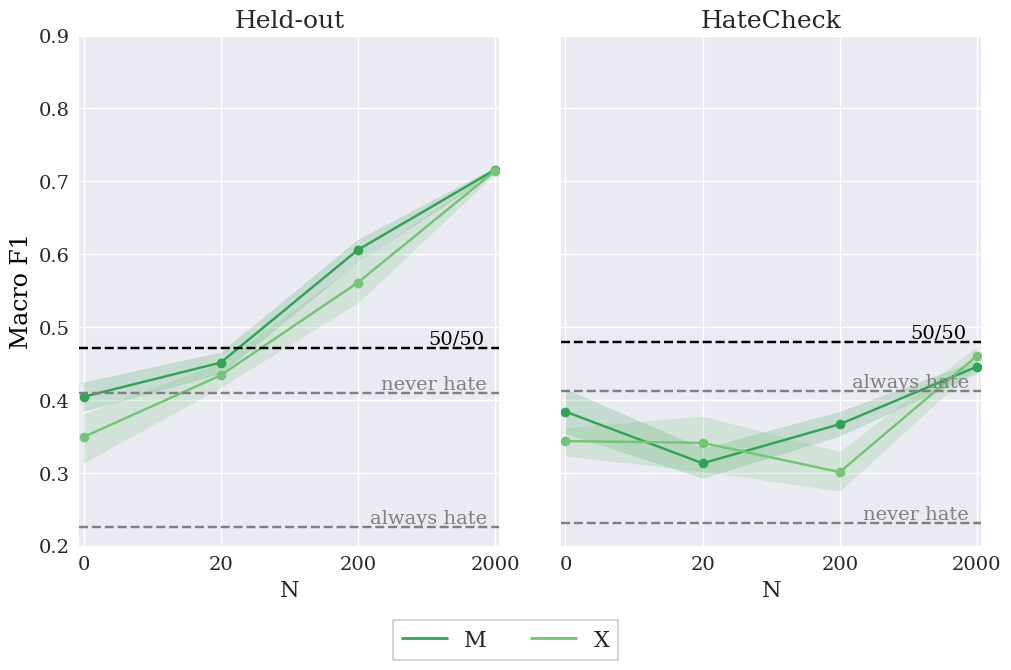

In [17]:
def compute_average(dictionary, string_key, in_or_not_in):
    if in_or_not_in:
        values = [value for key, value in dictionary.items() if string_key in key]
    else:
        values = [value for key, value in dictionary.items() if string_key not in key]
    return sum(values) / len(values)


def add_plot_to_fig(title: str, df: pd.DataFrame, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, fig, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    x_points = [0, 1, 2, 3]
    lines = []
    df_reset = df.reset_index()
    # convert the DataFrame from wide to long format
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    # now 'setting_strat' is a regular column and can be used in seaborn
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator='mean', marker='o', dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, palette=color_dict, markeredgecolor='none')  # err_kws={'alpha': 0.12},  edgecolor='none' 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
        
    
    # Add a custom legend entry for the dashed line
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [0, 1] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0] else False
        f1_rand_pred = avg_baselines_random_pred[testset]
        f1_never_hate = avg_baselines_never_hate[testset]
        f1_always_hate = avg_baselines_always_hate[testset]
        
        if testset == 'MHC':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)


    for ax, col in zip(axs, ['Held-out', 'HateCheck']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs, ['Macro F1']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black') # labelpad=35, 
    
    # Create the first row of the legend
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    # Create the first row of the legend
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.11), fontsize=16, fancybox=False, shadow=False, ncol=4, frameon=True) # , f handlelength=1.2
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()


### Prepare plotting function call

settings_to_include = ['M', 'X'] # ('X + DEN', 'baseline'), ('X + FEN', 'baseline')
test_set_to_ax = {'Held-out': 0, 'MHC': 1}

filtered_dfs = include_settings_dict(result_dict, settings_to_include)
result_dict_filtered = {
    'Held-out': calculate_pointwise_average(filtered_dfs['OUS19_AR'], filtered_dfs['BAS19_ES'], filtered_dfs['HAS21_HI'], filtered_dfs['SAN20_IT'], filtered_dfs['FOR19_PT']),
    'MHC': calculate_pointwise_average(filtered_dfs['MHC_AR'], filtered_dfs['MHC_ES'], filtered_dfs['MHC_HI'], filtered_dfs['MHC_IT'], filtered_dfs['MHC_PT'])
}

# average baselines
avg_baselines_random_pred = {
    'Held-out': compute_average(baselines_random_pred, 'MHC', False),
    'MHC': compute_average(baselines_random_pred, 'MHC', True)
}
avg_baselines_never_hate = {
    'Held-out': compute_average(baselines_never_hate, 'MHC', False),
    'MHC': compute_average(baselines_never_hate, 'MHC', True)
}
avg_baselines_always_hate = {
    'Held-out': compute_average(baselines_always_hate, 'MHC', False),
    'MHC': compute_average(baselines_always_hate, 'MHC', True)
}

create_multi_plot_figure(result_dict_filtered, test_set_to_ax, f'plots/M_X_avg_baselines_ci.pdf', title=None)

## Baselines (with En HS)

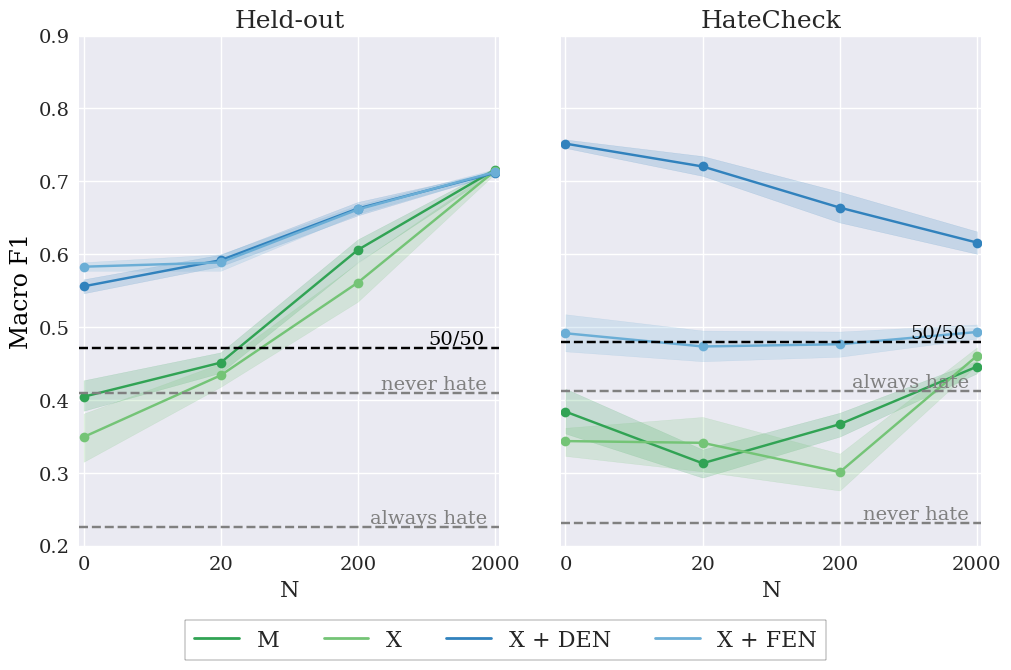

In [18]:
def compute_average(dictionary, string_key, in_or_not_in):
    if in_or_not_in:
        values = [value for key, value in dictionary.items() if string_key in key]
    else:
        values = [value for key, value in dictionary.items() if string_key not in key]
    return sum(values) / len(values)


def add_plot_to_fig(title: str, df: pd.DataFrame, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, fig, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    x_points = [0, 1, 2, 3]
    lines = []
    df_reset = df.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator='mean', marker='o', dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, palette=color_dict, markeredgecolor='none')  # err_kws={'alpha': 0.12},  edgecolor='none' 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
            
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [0, 1] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0] else False
        f1_rand_pred = avg_baselines_random_pred[testset]
        f1_never_hate = avg_baselines_never_hate[testset]
        f1_always_hate = avg_baselines_always_hate[testset]
        
        if testset == 'MHC':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)


    for ax, col in zip(axs, ['Held-out', 'HateCheck']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs, ['Macro F1']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black')
    
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.11), fontsize=16, fancybox=False, shadow=False, ncol=4, frameon=True) # , f handlelength=1.2
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()


settings_to_include = ['M', 'X', 'X + DEN', 'X + FEN']
test_set_to_ax = {'Held-out': 0, 'MHC': 1}

filtered_dfs = include_settings_dict(result_dict, settings_to_include)
result_dict_filtered = {
    'Held-out': calculate_pointwise_average(filtered_dfs['OUS19_AR'], filtered_dfs['BAS19_ES'], filtered_dfs['HAS21_HI'], filtered_dfs['SAN20_IT'], filtered_dfs['FOR19_PT']),
    'MHC': calculate_pointwise_average(filtered_dfs['MHC_AR'], filtered_dfs['MHC_ES'], filtered_dfs['MHC_HI'], filtered_dfs['MHC_IT'], filtered_dfs['MHC_PT'])
}

avg_baselines_random_pred = {
    'Held-out': compute_average(baselines_random_pred, 'MHC', False),
    'MHC': compute_average(baselines_random_pred, 'MHC', True)
}
avg_baselines_never_hate = {
    'Held-out': compute_average(baselines_never_hate, 'MHC', False),
    'MHC': compute_average(baselines_never_hate, 'MHC', True)
}
avg_baselines_always_hate = {
    'Held-out': compute_average(baselines_always_hate, 'MHC', False),
    'MHC': compute_average(baselines_always_hate, 'MHC', True)
}

create_multi_plot_figure(result_dict_filtered, test_set_to_ax, f'plots/M_X_DEN_FEN_avg_baselines_ci.pdf', title=None)

## NLI Fine-Tuning (no EN HS) (Averaged over all Languages)

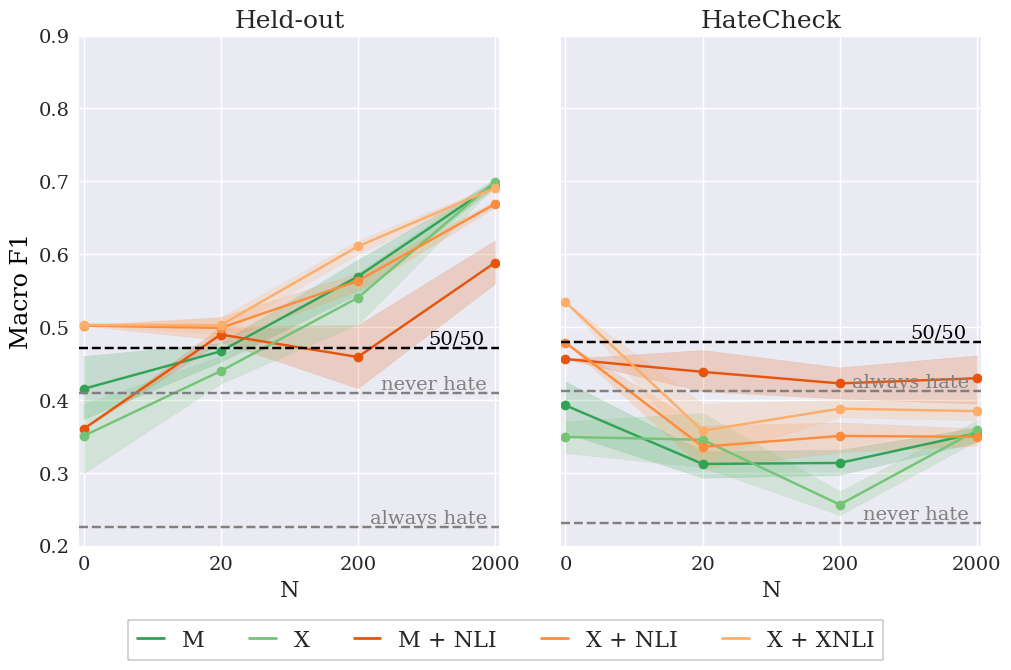

In [19]:
def compute_average(dictionary, string_key, in_or_not_in):
    if in_or_not_in:
        values = [value for key, value in dictionary.items() if string_key in key]
    else:
        values = [value for key, value in dictionary.items() if string_key not in key]
    return sum(values) / len(values)


def add_plot_to_fig(title: str, df: pd.DataFrame, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, fig, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    x_points = [0, 1, 2, 3]
    lines = []
    df_reset = df.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator='mean', marker='o', dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, palette=color_dict, markeredgecolor='none')  # err_kws={'alpha': 0.12},  edgecolor='none' 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
        
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [0, 1] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0] else False
        f1_rand_pred = avg_baselines_random_pred[testset]
        f1_never_hate = avg_baselines_never_hate[testset]
        f1_always_hate = avg_baselines_always_hate[testset]
        
        if testset == 'MHC':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)


    for ax, col in zip(axs, ['Held-out', 'HateCheck']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs, ['Macro F1']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black')
    
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.11), fontsize=16, fancybox=False, shadow=False, ncol=7, frameon=True, handlelength=1.2) # , f 
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()


settings_to_include = ['M', 'X', 'M + NLI', 'X + NLI', 'X + XNLI']
test_set_to_ax = {'Held-out': 0, 'MHC': 1}

filtered_dfs = include_settings_dict(result_dict, settings_to_include)
result_dict_filtered = {
    'Held-out': calculate_pointwise_average(filtered_dfs['OUS19_AR'], filtered_dfs['BAS19_ES'], filtered_dfs['HAS21_HI']),
    'MHC': calculate_pointwise_average(filtered_dfs['MHC_AR'], filtered_dfs['MHC_ES'], filtered_dfs['MHC_HI'])
}

avg_baselines_random_pred = {
    'Held-out': compute_average(baselines_random_pred, 'MHC', False),
    'MHC': compute_average(baselines_random_pred, 'MHC', True)
}
avg_baselines_never_hate = {
    'Held-out': compute_average(baselines_never_hate, 'MHC', False),
    'MHC': compute_average(baselines_never_hate, 'MHC', True)
}
avg_baselines_always_hate = {
    'Held-out': compute_average(baselines_always_hate, 'MHC', False),
    'MHC': compute_average(baselines_always_hate, 'MHC', True)
}

create_multi_plot_figure(result_dict_filtered, test_set_to_ax, f'plots/M_X_XNLI_avg_baselines_ci.pdf', title=None)

## NLI Fine-Tuning (with En HS) (Averaged over language in XNLI)

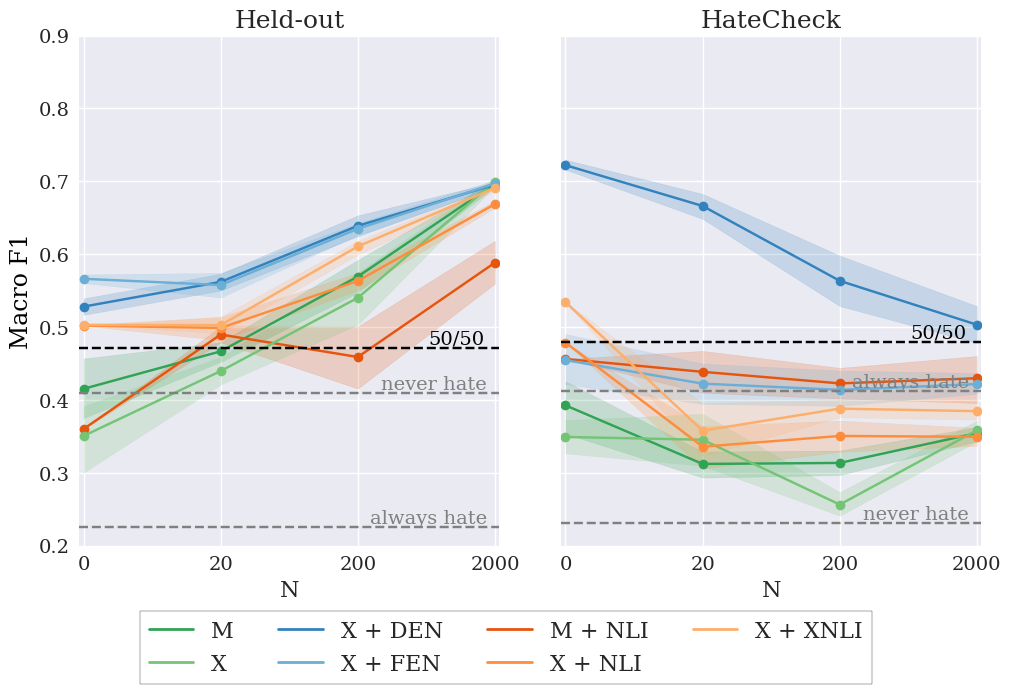

In [20]:
def compute_average(dictionary, string_key, in_or_not_in):
    if in_or_not_in:
        values = [value for key, value in dictionary.items() if string_key in key]
    else:
        values = [value for key, value in dictionary.items() if string_key not in key]
    return sum(values) / len(values)


def add_plot_to_fig(title: str, df: pd.DataFrame, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, fig, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    x_points = [0, 1, 2, 3]
    lines = []
    df_reset = df.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator='mean', marker='o', dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, palette=color_dict, markeredgecolor='none')  # err_kws={'alpha': 0.12},  edgecolor='none' 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
        
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [0, 1] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0] else False
        f1_rand_pred = avg_baselines_random_pred[testset]
        f1_never_hate = avg_baselines_never_hate[testset]
        f1_always_hate = avg_baselines_always_hate[testset]
        
        if testset == 'MHC':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)


    for ax, col in zip(axs, ['Held-out', 'HateCheck']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs, ['Macro F1']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black')
    
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.15), fontsize=16, fancybox=False, shadow=False, ncol=4, frameon=True) # , f handlelength=1.2
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()

settings_to_include = ['M', 'X', 'X + DEN', 'X + FEN', 'M + NLI', 'X + NLI', 'X + XNLI']
test_set_to_ax = {'Held-out': 0, 'MHC': 1}

filtered_dfs = include_settings_dict(result_dict, settings_to_include)
result_dict_filtered = {
    'Held-out': calculate_pointwise_average(filtered_dfs['OUS19_AR'], filtered_dfs['BAS19_ES'], filtered_dfs['HAS21_HI']), 
    'MHC': calculate_pointwise_average(filtered_dfs['MHC_AR'], filtered_dfs['MHC_ES'], filtered_dfs['MHC_HI'])
}

avg_baselines_random_pred = {
    'Held-out': compute_average(baselines_random_pred, 'MHC', False),
    'MHC': compute_average(baselines_random_pred, 'MHC', True)
}
avg_baselines_never_hate = {
    'Held-out': compute_average(baselines_never_hate, 'MHC', False),
    'MHC': compute_average(baselines_never_hate, 'MHC', True)
}
avg_baselines_always_hate = {
    'Held-out': compute_average(baselines_always_hate, 'MHC', False),
    'MHC': compute_average(baselines_always_hate, 'MHC', True)
}

create_multi_plot_figure(result_dict_filtered, test_set_to_ax, f'plots/M_X_DEN_FEN_XNLI_avg_ci.pdf', title=None)

## NLI Fine-Tuning + En HS (Averaged over all Languages)

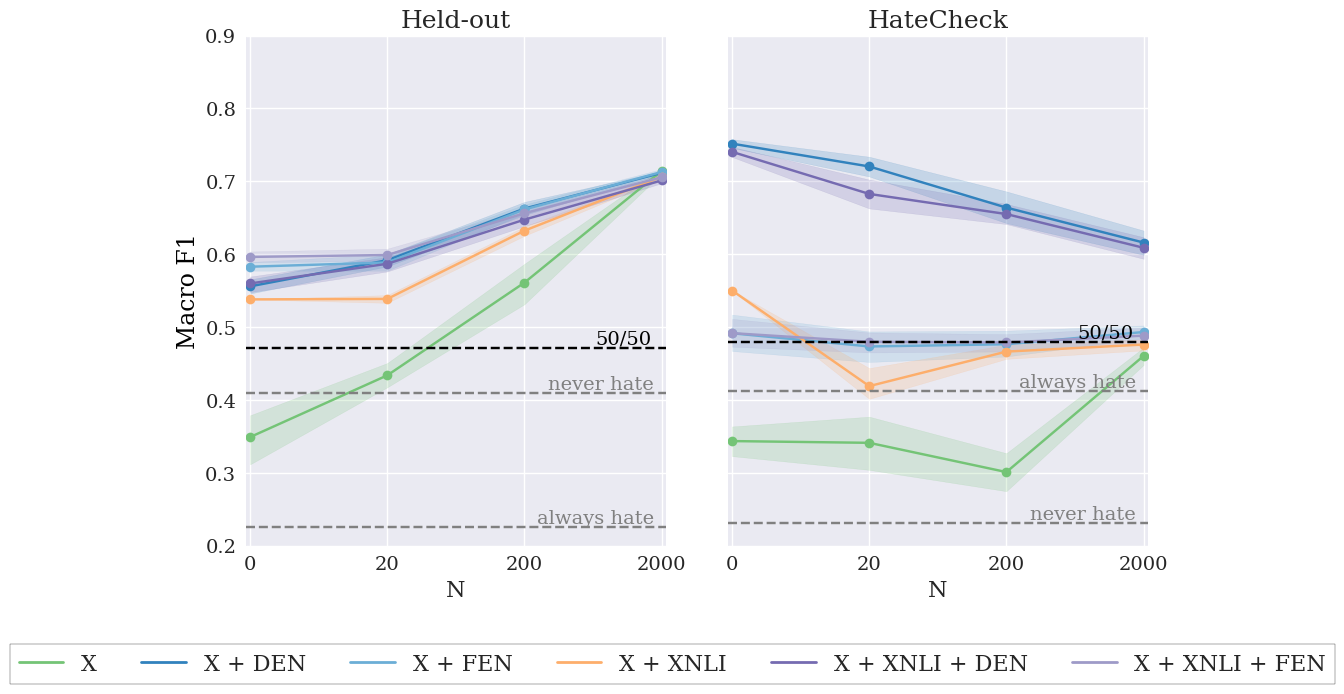

In [21]:
def compute_average(dictionary, string_key, in_or_not_in):
    if in_or_not_in:
        values = [value for key, value in dictionary.items() if string_key in key]
    else:
        values = [value for key, value in dictionary.items() if string_key not in key]
    return sum(values) / len(values)


def add_plot_to_fig(title: str, df: pd.DataFrame, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, fig, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    x_points = [0, 1, 2, 3]
    lines = []
    df_reset = df.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator='mean', marker='o', dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, palette=color_dict, markeredgecolor='none')  # err_kws={'alpha': 0.12},  edgecolor='none' 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
        
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [0, 1] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0] else False
        f1_rand_pred = avg_baselines_random_pred[testset]
        f1_never_hate = avg_baselines_never_hate[testset]
        f1_always_hate = avg_baselines_always_hate[testset]
        
        if testset == 'MHC':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)


    for ax, col in zip(axs, ['Held-out', 'HateCheck']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs, ['Macro F1']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black')
    
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.15), fontsize=16, fancybox=False, shadow=False, ncol=6, frameon=True) # , f handlelength=1.2
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()


settings_to_include = ['X', 'X + DEN', 'X + FEN', 'X + XNLI', 'X + XNLI + DEN', 'X + XNLI + FEN']
test_set_to_ax = {'Held-out': 0, 'MHC': 1}

filtered_dfs = include_settings_dict(result_dict, settings_to_include)
result_dict_filtered = {
    'Held-out': calculate_pointwise_average(filtered_dfs['OUS19_AR'], filtered_dfs['BAS19_ES'], filtered_dfs['HAS21_HI'], filtered_dfs['SAN20_IT'], filtered_dfs['FOR19_PT']),
    'MHC': calculate_pointwise_average(filtered_dfs['MHC_AR'], filtered_dfs['MHC_ES'], filtered_dfs['MHC_HI'], filtered_dfs['MHC_IT'], filtered_dfs['MHC_PT'])
}

avg_baselines_random_pred = {
    'Held-out': compute_average(baselines_random_pred, 'MHC', False),
    'MHC': compute_average(baselines_random_pred, 'MHC', True)
}
avg_baselines_never_hate = {
    'Held-out': compute_average(baselines_never_hate, 'MHC', False),
    'MHC': compute_average(baselines_never_hate, 'MHC', True)
}
avg_baselines_always_hate = {
    'Held-out': compute_average(baselines_always_hate, 'MHC', False),
    'MHC': compute_average(baselines_always_hate, 'MHC', True)
}

create_multi_plot_figure(result_dict_filtered, test_set_to_ax, f'plots/NLI_EN_HS_avg_ci.pdf', title=None)

## Hypothesis Engineering

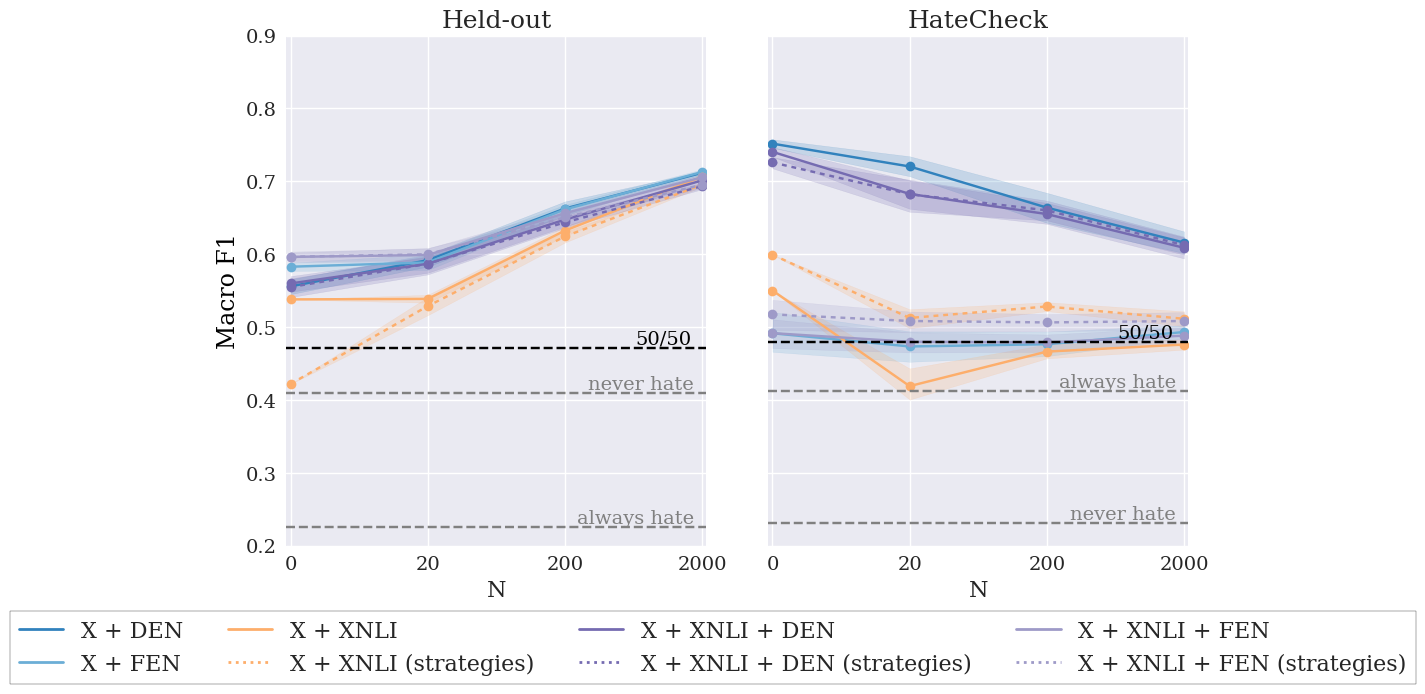

In [22]:
def compute_average(dictionary, string_key, in_or_not_in):
    if in_or_not_in:
        values = [value for key, value in dictionary.items() if string_key in key]
    else:
        values = [value for key, value in dictionary.items() if string_key not in key]
    return sum(values) / len(values)


def add_plot_to_fig(title: str, df: pd.DataFrame, f1_rand_pred: float, f1_never_hate: float, f1_always_hate, ax, fig, annotate_x_axis: bool = True, annotate_y_axis: bool = True) -> None:  # list_of_colors: List[str],
    x_points = [0, 1, 2, 3]
    lines = []
    df_reset = df.reset_index()
    df_long = df_reset.melt(id_vars='trainsize', var_name=['setting_strat', 'strategy', 'run'], value_name='value')
    strategy_linestyles = {True: (2, 2), False: (1, 0)}
    p_ax = sns.lineplot(x='trainsize', y='value', hue='setting_strat', data=df_long, estimator='mean', marker='o', dashes=strategy_linestyles, style='strategy', errorbar=('ci', 95), err_style='band', ax=ax, palette=color_dict, markeredgecolor='none')  # err_kws={'alpha': 0.12},  edgecolor='none' 
    p_ax.legend_.remove()
    
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
        
    rand_line = ax.axhline(y=f1_rand_pred, color='black', linestyle='--')
    never_hate_line = ax.axhline(y=f1_never_hate, color='grey', linestyle='--')
    always_hate_line = ax.axhline(y=f1_always_hate, color='grey', linestyle='--')
    ax.annotate('50/50', xy=(3, f1_rand_pred), textcoords="offset points", xytext=(-48, 3), fontsize=14, color=rand_line.get_color())
    ax.annotate('never hate', xy=(3, f1_never_hate), textcoords="offset points", xytext=(-82, 3), fontsize=14, color=never_hate_line.get_color())
    ax.annotate('always hate', xy=(3, f1_always_hate), textcoords="offset points", xytext=(-90, 3), fontsize=14, color=always_hate_line.get_color())
    
    ax.set_xlim(-0.03, 3.03)
    if annotate_x_axis:
        ax.set_xticks(x_points)
        ax.set_xticklabels(['0', '20', '200', '2000'], fontsize=14)
        ax.set_xlabel('N', fontsize=16)
    else:
        ax.set_xticks(x_points)
        ax.tick_params(axis='x', colors='white', which='both', bottom=False)
        ax.set_xticklabels(['', '', '', ''])
    
    
    ytick_values = [y/100 for y in range(0, 101, 10)]
    if annotate_y_axis:
        ax.set_yticks(ytick_values)
        ax.set_yticklabels(ytick_values, fontsize=14)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('Macro F1', fontsize=15)
    else:
        ax.set_yticks(ytick_values)
        ax.tick_params(axis='y', colors='white', which='both', bottom=False)
        ax.set_ylim(0.2, 0.9)
        ax.set_ylabel('', fontsize=15)
        
    
    legend_elements = []
    for line, label in zip(lines, labels):
        if 'strategies' in label:
            linestyle = 'dotted'
        else:
            linestyle = '-'
        legend_elements.append(Line2D([0], [0], lw=2, label=label, color=line.get_color(), linestyle=linestyle))
        
    ax.xaxis.set_minor_formatter(plt.NullFormatter())
    return legend_elements


def create_multi_plot_figure(df, test_set_to_ax, fpath, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), layout='constrained')    
    axs_list = axs.flatten()

    for testset, df in df.items():
        ax = axs_list[test_set_to_ax[testset]]
        annotate_x_axis = True if test_set_to_ax[testset] in [0, 1] else False
        annotate_y_axis = True if test_set_to_ax[testset] in [0] else False
        f1_rand_pred = avg_baselines_random_pred[testset]
        f1_never_hate = avg_baselines_never_hate[testset]
        f1_always_hate = avg_baselines_always_hate[testset]
        
        if testset == 'MHC':
            legend_elements = add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)
        else:
            add_plot_to_fig(title=testset, df=df, f1_rand_pred=f1_rand_pred, f1_never_hate=f1_never_hate, f1_always_hate=f1_always_hate, ax=ax, fig=fig, annotate_x_axis=annotate_x_axis, annotate_y_axis=annotate_y_axis)


    for ax, col in zip(axs, ['Held-out', 'HateCheck']):
        ax.set_title(col, fontsize=18)
    for ax, row in zip(axs, ['Macro F1']):
        ax.set_ylabel(row, rotation=90, fontsize=17, color='black')
    
    legend_elements_filtered = [le for le in legend_elements if le.get_label() not in ['setting_strat', 'strategy', 'False', 'True'] and not le.get_label().startswith('_')]
    legend_elements_sorted = sorted(legend_elements_filtered, key=lambda x: custom_sort(x.get_label()))
    
    legend1 = fig.legend(handles=legend_elements_sorted, loc='outside lower center', bbox_to_anchor=(0.5, -0.15), fontsize=16, fancybox=False, shadow=False, ncol=4, frameon=True) # , f handlelength=1.2
    legend1.get_frame().set_edgecolor('black')
    legend1.get_frame().set_facecolor('none')    
    
    if title:
        fig.suptitle(title, fontsize=17)
    plt.savefig(fpath, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()


settings_to_include = ['X + DEN', 'X + FEN', 'X + XNLI', 'X + XNLI (strategies)', 'X + XNLI + DEN', 'X + XNLI + DEN (strategies)', 'X + XNLI + FEN', 'X + XNLI + FEN (strategies)']
test_set_to_ax = {'Held-out': 0, 'MHC': 1}

filtered_dfs = include_settings_dict(result_dict, settings_to_include)
result_dict_filtered = {
    'Held-out': calculate_pointwise_average(filtered_dfs['OUS19_AR'], filtered_dfs['BAS19_ES'], filtered_dfs['HAS21_HI'], filtered_dfs['SAN20_IT'], filtered_dfs['FOR19_PT']),
    'MHC': calculate_pointwise_average(filtered_dfs['MHC_AR'], filtered_dfs['MHC_ES'], filtered_dfs['MHC_HI'], filtered_dfs['MHC_IT'], filtered_dfs['MHC_PT'])
}

avg_baselines_random_pred = {
    'Held-out': compute_average(baselines_random_pred, 'MHC', False),
    'MHC': compute_average(baselines_random_pred, 'MHC', True)
}
avg_baselines_never_hate = {
    'Held-out': compute_average(baselines_never_hate, 'MHC', False),
    'MHC': compute_average(baselines_never_hate, 'MHC', True)
}
avg_baselines_always_hate = {
    'Held-out': compute_average(baselines_always_hate, 'MHC', False),
    'MHC': compute_average(baselines_always_hate, 'MHC', True)
}

create_multi_plot_figure(result_dict_filtered, test_set_to_ax, f'plots/hypo_eng_avg_ci.pdf', title=None)